In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import arviz as az
import pymc3 as pm
from causalgraphicalmodels import CausalGraphicalModel
from copy import deepcopy
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
np.set_printoptions(formatter={float: lambda x: '{:,.3f}'.format(x)})
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

In [4]:
def create_standardizer_destandardizer(s: np.ndarray) -> np.ndarray:
    return lambda x: (x - s.mean()) / s.std(), lambda x: (x * s.std()) + s.mean()

# The Many Variables & The Spurious Waffles

## Practice

### 5E1. 

Which of the linear models below are multiple linear regressions?

- (1) $\mu_i = \alpha + \beta_{x_i}$
- (2) $\mu_i = \beta_x x_i + \beta_z z_i$
- (3) $\mu_i = \alpha + \beta(x_i − z_i)$
- (4) $\mu_i = \alpha + \beta_x x_i + \beta_z z_i$

**Answer:** (4)

### 5E2. 
Write down a multiple regression to evaluate the claim: *Animal diversity is linearly related to latitude, but only after controlling for plant diversity*. You just need to write down the model definition.

**Answer:**

- $L$: Latitude
- $P$: Plant Diversity
- $A$: Animal Diversity

$$
\alpha \sim Normal(0, 0.2) \\
\beta_L \sim Normal(0, 0.5) \\
\beta_P \sim Normal(0, 0.5) \\
\mu = \alpha + \beta_L L_i + \beta_P P_i \\
\sigma \sim Exponential(1) \\
A_i \sim Normal(\mu, \sigma)
$$

### 5E3. 

Write down a multiple regression to evaluate the claim: *Neither amount of funding nor size of laboratory is by itself a good predictor of time to PhD degree; but together these variables are both positively associated with time to degree.* Write down the model definition and indicate which side of zero each slope parameter should be on.

**Answer:**

$$ 
T_i = \alpha + \beta_F F_i + \beta_S S_i \\
\beta_F > 0 \\
\beta_S > 0
$$

### 5E4. 

Suppose you have a single categorical predictor with 4 levels (unique values), labeled $A$, $B$, $C$ and $D$. Let $A_i$ be an indicator variable that is 1 where case $i$ is in category $A$. Also suppose $B_i$, $C_i$, and $D_i$ for the other categories. Now which of the following linear models are inferentially equivalent ways to include the categorical variable in a regression? Models are inferentially equivalent when it's possible to compute one posterior distribution from the posterior distribution of another model.

- (1) $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_D D_i$
- (2) $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_C C_i + \beta_D D_i$
- (3) $\mu_i = \alpha + \beta_B B_i + \beta_C C_i + \beta_D D_i$
- (4) $\mu_i = \alpha_A A_i + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$
- (5) $\mu_i = \alpha_A (1 − B_i − C_i − D_i) + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$

**Answer:** (2), (4) and (5)

(1) is not equivalent because value $A$, $B$, $D$ will be affected by one more uncertainty compared to $C$

(3) is equivalent to (1)


### 5M1. 
Invent your own example of a spurious correlation. An outcome variable should be correlated
with both predictor variables. But when both predictors are entered in the same model, the correlation
between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

In [5]:
T = np.random.normal(23, 5, size=1000)
S = np.round(np.clip(np.random.normal(T/5, 2), a_min=0, a_max=None), 0)
I = np.random.normal(T*10000, 30000)

d = pd.DataFrame({'T': T, 'S': S, 'I': I})

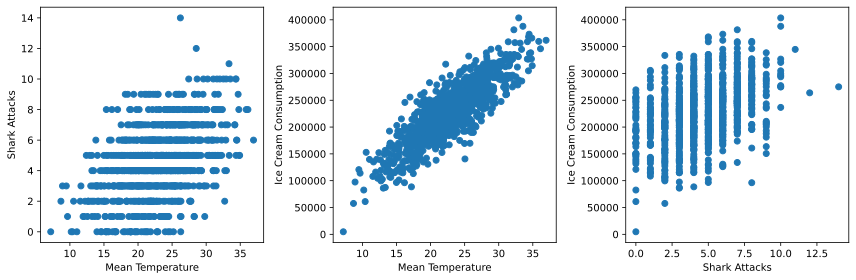

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(d['T'], d['S'])
ax1.set_xlabel('Mean Temperature')
ax1.set_ylabel('Shark Attacks')

ax2.scatter(d['T'], d['I'])
ax2.set_xlabel('Mean Temperature')
ax2.set_ylabel('Ice Cream Consumption')

ax3.scatter(d['S'], d['I'])
ax3.set_xlabel('Shark Attacks')
ax3.set_ylabel('Ice Cream Consumption')

fig.tight_layout()
plt.show()

In [7]:
std_T, dstd_T = create_standardizer_destandardizer(d['T'])
std_S, dstd_S = create_standardizer_destandardizer(d['S'])
std_I, dstd_I = create_standardizer_destandardizer(d['I'])

#### X=Shark 

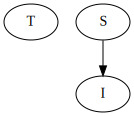

In [8]:
CausalGraphicalModel(
    nodes=['S', 'T', 'I'],
    edges=[
        ('S', 'I')
    ]
).draw()

In [9]:
with pm.Model() as model_1:
    α = pm.Normal('α', 0, .2)
    β_S = pm.Normal('β_S', 0, .5)
    S = pm.Data('S', std_S(d['S']))
    μ = pm.Deterministic('μ', α + β_S*S)
    σ = pm.Exponential('σ', 1)
    I = pm.Normal('I', μ, σ, observed=std_I(d['I']))
    trace_1 = pm.sample()

<ipython-input-9-7266eb09a422>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_S, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


In [10]:
az.summary(trace_1, kind='stats', hdi_prob=.89, var_names=['α', 'β_S'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
α,0.000,0.030,-0.045,0.049
β_S,0.407,0.030,0.364,0.456


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:>

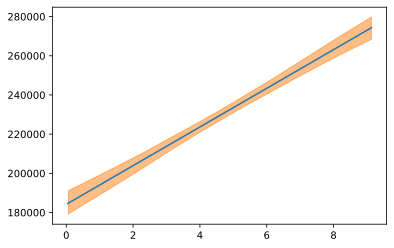

In [11]:
with deepcopy(model_1):
    xseq = np.linspace(-2, 2, 30)
    pm.set_data({'S': xseq})
    yseq = pm.sample_posterior_predictive(trace_1, var_names=['μ'])['μ']
    
fig, ax = plt.subplots(1, 1)
ax.plot(dstd_S(xseq), dstd_I(yseq.mean(axis=0)))
az.plot_hdi(dstd_S(xseq), dstd_I(yseq), hdi_prob=.89, ax=ax)

#### X=Temperature

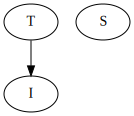

In [12]:
CausalGraphicalModel(
    nodes=['S', 'T', 'I'],
    edges=[
        ('T', 'I')
    ]
).draw()

In [13]:
with pm.Model() as model_2:
    α = pm.Normal('α', 0, .2)
    β_T = pm.Normal('β_T', 0, .5)
    T = pm.Data('T', std_T(d['T']))
    μ = pm.Deterministic('μ', α + β_T*T)
    σ = pm.Exponential('σ', 1)
    I = pm.Normal('I', μ, σ, observed=std_I(d['I']))
    trace_2 = pm.sample()

<ipython-input-13-19248b5bafc9>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_2 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_T, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [14]:
az.summary(trace_2, kind='stats', hdi_prob=.89, var_names=['α', 'β_T'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
α,-0.000,0.017,-0.029,0.025
β_T,0.852,0.017,0.826,0.880


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:>

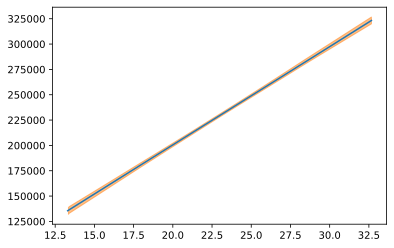

In [15]:
with deepcopy(model_2):
    xseq = np.linspace(-2, 2, 30)
    pm.set_data({'T': xseq})
    yseq = pm.sample_posterior_predictive(trace_2, var_names=['μ'])['μ']
    
fig, ax = plt.subplots(1, 1)
ax.plot(dstd_T(xseq), dstd_I(yseq.mean(axis=0)))
az.plot_hdi(dstd_T(xseq), dstd_I(yseq), hdi_prob=.89, ax=ax)

#### X=[Shark, Temperature]

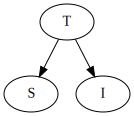

In [16]:
dag = CausalGraphicalModel(
    nodes=['S', 'T', 'I'],
    edges=[
        ('T', 'S'),
        ('T', 'I')
    ]
)
dag.draw()

In [17]:
dag.get_all_independence_relationships()

[('S', 'I', {'T'})]

In [18]:
with pm.Model() as model_3:
    α = pm.Normal('α', 0, .2)
    β_S = pm.Normal('β_S', 0, .5)
    β_T = pm.Normal('β_T', 0, .5)
    S = pm.Data('S', std_S(d['S']))
    T = pm.Data('T', std_T(d['T']))
    μ = pm.Deterministic('μ', α + β_S*S + β_T*T)
    σ = pm.Exponential('σ', 1)
    I = pm.Normal('I', μ, σ, observed=std_I(d['I']))
    trace_3 = pm.sample()

<ipython-input-18-43e7a44e93c6>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_3 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_T, β_S, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [19]:
az.summary(trace_3, kind='stats', hdi_prob=.89, var_names=['α', 'β_S', 'β_T'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
α,-0.000,0.017,-0.027,0.028
β_S,0.013,0.019,-0.018,0.043
β_T,0.847,0.019,0.815,0.876


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


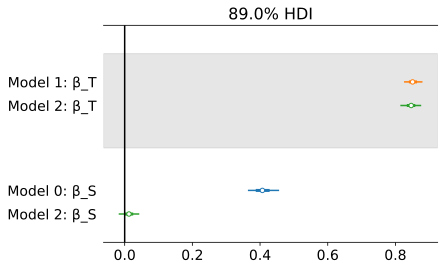

In [20]:
fig, ax = plt.subplots()
az.plot_forest([trace_1, trace_2, trace_3], var_names=['β_T', 'β_S'], hdi_prob=.89, combined=True, ax=ax)
ax.axvline(0, color='black')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


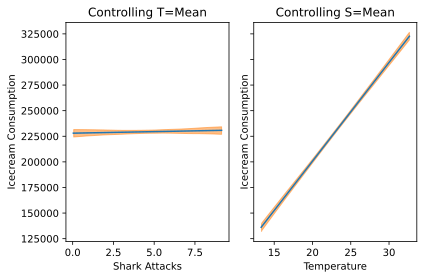

In [21]:
with deepcopy(model_3):
    xseq = np.linspace(-2, 2, 30)
    pm.set_data({'S': xseq, 'T': np.zeros(len(xseq))})
    yseq_controlling_T = pm.sample_posterior_predictive(trace_3, var_names=['μ'])['μ']
    pm.set_data({'T': xseq, 'S': np.zeros(len(xseq))})
    yseq_controlling_S = pm.sample_posterior_predictive(trace_3, var_names=['μ'])['μ']

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(dstd_S(xseq), dstd_I(yseq_controlling_T.mean(axis=0)))
az.plot_hdi(dstd_S(xseq), dstd_I(yseq_controlling_T), hdi_prob=.89, ax=ax1)
ax1.set_xlabel('Shark Attacks')
ax1.set_ylabel('Icecream Consumption')
ax1.set_title('Controlling T=Mean')

ax2.plot(dstd_T(xseq), dstd_I(yseq_controlling_S.mean(axis=0)))
az.plot_hdi(dstd_T(xseq), dstd_I(yseq_controlling_S), hdi_prob=.89, ax=ax2)
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Icecream Consumption')
ax2.set_title('Controlling S=Mean')

fig.tight_layout()
plt.show()

### 5M2.
Invent your own example of a masked relationship. An outcome variable should be correlated
with both predictor variables, but in opposite directions. And the two predictor variables should be
correlated with one another.

In [22]:
X = np.random.normal(size=50)
Y = np.random.normal(X)
Z = np.random.normal(X-Y, 1.5)

d = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


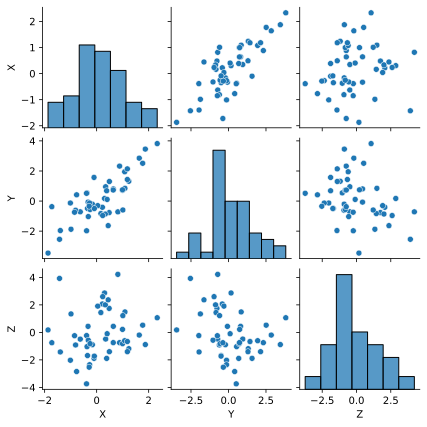

In [23]:
sns.pairplot(d, size=2)

#### X -> Z

[('Z', 'Y', set()), ('Z', 'Y', {'X'}), ('Y', 'X', set()), ('Y', 'X', {'Z'})]


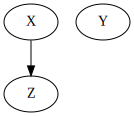

In [24]:
dag = CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'],
    edges=[
        ('X', 'Z'),
    ]
)
print(dag.get_all_independence_relationships())
dag.draw()

In [25]:
with pm.Model() as model_1:
    a = pm.Normal('a', 0, .5)
    bX = pm.Normal('bX', 0, .2)
    X = pm.Data('X', d['X'])
    mu = pm.Deterministic('mu', a + bX*X)
    sigma = pm.Exponential('sigma', 1)
    Z = pm.Normal('Z', mu, sigma, observed=d['Z'])
    trace_1 = pm.sample()

<ipython-input-25-4d627f737a96>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bX, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [26]:
az.summary(trace_1, var_names=['a', 'bX', 'sigma'], hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.104,0.226,-0.482,0.231
bX,0.105,0.160,-0.154,0.355
sigma,1.724,0.175,1.460,2.008


In [27]:
with deepcopy(model_1):
    xgrid = np.linspace(-2, 2, 30)
    pm.set_data({'X': xgrid})
    ygrid = pm.sample_posterior_predictive(trace_1, var_names=['mu'])['mu']

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'Z')

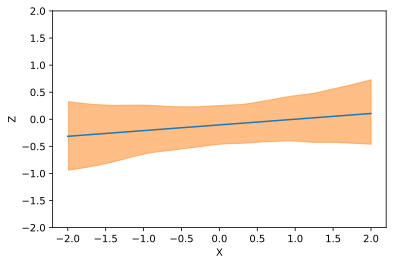

In [28]:
fig, ax = plt.subplots()
ax.plot(xgrid, ygrid.mean(axis=0))
ax.set_ylim(-2, 2)
az.plot_hdi(xgrid, ygrid, hdi_prob=.89, ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Z')

#### Y -> Z

[('Z', 'X', set()), ('Z', 'X', {'Y'}), ('Y', 'X', set()), ('Y', 'X', {'Z'})]


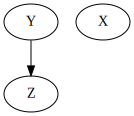

In [29]:
dag = CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'],
    edges=[
        ('Y', 'Z')
    ]
)
print(dag.get_all_independence_relationships())
dag.draw()

In [30]:
with pm.Model() as model_2:
    a = pm.Normal('a', 0, .5)
    bY = pm.Normal('bY', 0, .2)
    Y = pm.Data('Y', d['Y'])
    mu = pm.Deterministic('mu', a + bY*Y)
    sigma = pm.Exponential('sigma', 1)
    Z = pm.Normal('Z', mu, sigma, observed=d['Z'])
    trace_2 = pm.sample()

<ipython-input-30-b956178f09de>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_2 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bY, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [31]:
az.summary(trace_2, var_names=['a', 'bY', 'sigma'], hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.059,0.226,-0.419,0.291
bY,-0.197,0.127,-0.394,0.006
sigma,1.682,0.175,1.402,1.944


In [32]:
with deepcopy(model_2):
    xgrid = np.linspace(-2, 2, 30)
    pm.set_data({'Y': xgrid})
    ygrid = pm.sample_posterior_predictive(trace_2, var_names=['mu'])['mu']

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'Z')

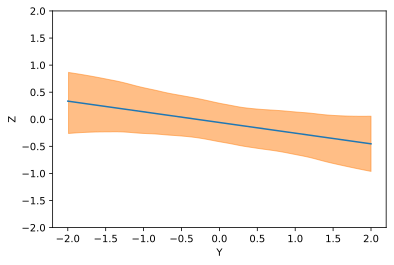

In [33]:
fig, ax = plt.subplots()
ax.plot(xgrid, ygrid.mean(axis=0))
ax.set_ylim(-2, 2)
az.plot_hdi(xgrid, ygrid, hdi_prob=.89, ax=ax)
ax.set_xlabel('Y')
ax.set_ylabel('Z')

#### X, Y -> Z

[('Y', 'X', set())]


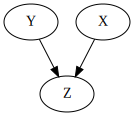

In [34]:
dag = CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'],
    edges=[
        ('X', 'Z'),
        ('Y', 'Z'),
    ]
)
print(dag.get_all_independence_relationships())
dag.draw()

In [35]:
with pm.Model() as model_3:
    a = pm.Normal('a', 0, .5)
    bY = pm.Normal('bY', 0, .2)
    bX = pm.Normal('bX', 0, .2)
    Y = pm.Data('Y', d['Y'])
    X = pm.Data('X', d['X'])
    mu = pm.Deterministic('mu', a + bY*Y + bX*X)
    sigma = pm.Exponential('sigma', 1)
    Z = pm.Normal('Z', mu, sigma, observed=d['Z'])
    trace_3 = pm.sample()

<ipython-input-35-459a5977b126>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_3 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bX, bY, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


In [36]:
az.summary(trace_3, var_names=['a', 'bX', 'bY', 'sigma'], hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.087,0.210,-0.430,0.230
bX,0.261,0.171,-0.046,0.505
bY,-0.288,0.137,-0.492,-0.053
sigma,1.601,0.176,1.317,1.860


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


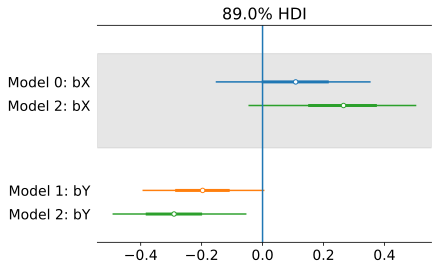

In [37]:
fig, ax = plt.subplots()
az.plot_forest([trace_1, trace_2, trace_3], combined=True, hdi_prob=.89, var_names=['bX', 'bY'], ax=ax)
ax.axvline(0)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


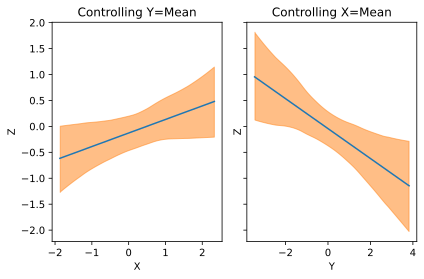

In [38]:
with deepcopy(model_3):
    seq_X = np.linspace(d['X'].min(), d['X'].max(), 30)
    pm.set_data({'X': seq_X, 'Y': np.repeat(d['Y'].mean(), len(seq_X))})
    seq_X_Z = pm.sample_posterior_predictive(trace_3, var_names=['mu'])['mu']
    
    seq_Y = np.linspace(d['Y'].min(), d['Y'].max(), 30)
    pm.set_data({'Y': seq_Y, 'X': np.repeat(d['X'].mean(), len(seq_Y))})
    seq_Y_Z = pm.sample_posterior_predictive(trace_3, var_names=['mu'])['mu']
    
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(seq_X, seq_X_Z.mean(axis=0))
az.plot_hdi(seq_X, seq_X_Z, hdi_prob=.89, ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_title('Controlling Y=Mean')

ax2.plot(seq_Y, seq_Y_Z.mean(axis=0))
az.plot_hdi(seq_Y, seq_Y_Z, hdi_prob=.89, ax=ax2)
ax2.set_xlabel('Y')
ax2.set_ylabel('Z')
ax2.set_title('Controlling X=Mean')

fig.tight_layout()
plt.show()

#### X -> Y | X, Y -> Z

[]


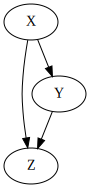

In [39]:
dag = CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'],
    edges=[
        ('X', 'Z'),
        ('Y', 'Z'),
        ('X', 'Y'),
    ]
)
print(dag.get_all_independence_relationships())
dag.draw()

In [40]:
with pm.Model() as model_4:
    a_Z = pm.Normal('a_Z', 0, .5)
    bX_Z = pm.Normal('bX_Z', 0, .2)
    bY_Z = pm.Normal('bY_Z', 0, .2)
    
    a_Y = pm.Normal('a_Y', 0, .5)
    bX_Y = pm.Normal('bX_Y', 0, .2)
    
    mu_Z = a_Z + bX_Z*d['X'] + bY_Z*d['Y']
    mu_Y = a_Y + bX_Y*d['X']
    
    sigma_Z = pm.Exponential('sigma_Z', 1)
    sigma_Y = pm.Exponential('sigma_Y', 1)
    
    Z = pm.Normal('Z', mu_Z, sigma_Z, observed=d['Z'])
    Y = pm.Normal('Y', mu_Y, sigma_Y, observed=d['Y'])
    
    trace_4 = pm.sample()

<ipython-input-40-67a822482ca6>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_Y, sigma_Z, bX_Y, a_Y, bY_Z, bX_Z, a_Z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


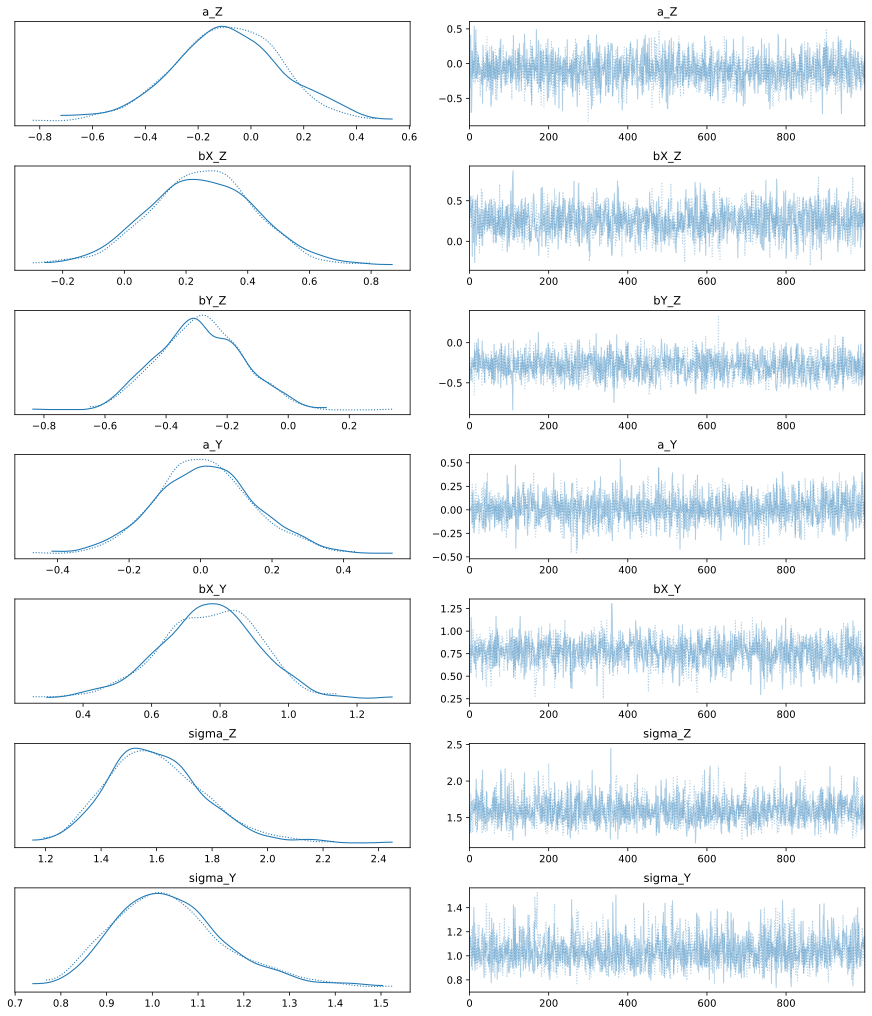

In [41]:
pm.plot_trace(trace_4)
plt.show()

In [42]:
az.summary(trace_4, hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a_Z,-0.091,0.205,-0.426,0.229
bX_Z,0.251,0.174,-0.005,0.540
bY_Z,-0.288,0.137,-0.510,-0.066
a_Y,0.013,0.139,-0.236,0.216
bX_Y,0.766,0.142,0.535,0.983
sigma_Z,1.600,0.173,1.331,1.862
sigma_Y,1.040,0.125,0.841,1.232


In [43]:
X_seq = np.linspace(d['X'].min(), d['X'].max(), 30)

Y_mu_seq = trace_4['a_Y'] + np.outer(X_seq, trace_4['bX_Y'])
Y_sim_seq = stats.norm(Y_mu_seq, trace_4['sigma_Y']).rvs()

Z_mu_seq = trace_4['a_Z'] + np.outer(X_seq, trace_4['bX_Z']) + np.multiply(Y_sim_seq, trace_4['bY_Z'])
Z_sim_seq = stats.norm(Z_mu_seq, trace_4['sigma_Z']).rvs()


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


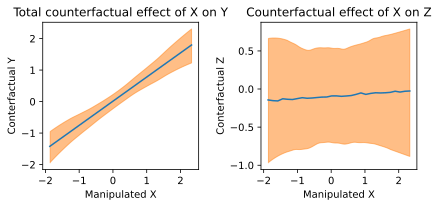

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.plot(X_seq, Y_mu_seq.mean(axis=1))
az.plot_hdi(X_seq, Y_mu_seq.T, hdi_prob=.89, ax=ax1)
ax1.set_xlabel('Manipulated X')
ax1.set_ylabel('Conterfactual Y')
ax1.set_title('Total counterfactual effect of X on Y')

ax2.plot(X_seq, Z_mu_seq.mean(axis=1))
az.plot_hdi(X_seq, Z_mu_seq.T, hdi_prob=.89, ax=ax2)
ax2.set_xlabel('Manipulated X')
ax2.set_ylabel('Conterfactual Z')
ax2.set_title('Counterfactual effect of X on Z')

fig.tight_layout()
plt.show()

### 5M3.
It is sometimes observed that the best predictor of fire risk is the presence of firefighters—
States and localities with many firefighters also have more fires. Presumably firefighters do not cause
fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the
same reversal of causal inference in the context of the divorce and marriage data. How might a high
divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship, using
multiple regression?

**Answer:**

A high divorce rate will create more single persons, which will marry again thus increasing the marriage rate. We cannot establish the direction of the relationshiop between two variables using a simple multiple regression.

### 5M4.
In the divorce data, States with high numbers of members of the Church of Jesus Christ of
Latter-day Saints (LDS) have much lower divorce rates than the regression models expected. Find a
list of LDS population by State and use those numbers as a predictor variable, predicting divorce rate
using marriage rate, median age at marriage, and percent LDS population (possibly standardized).
You may want to consider transformations of the raw percent LDS variable.

In [45]:
lds_state = pd.read_html("https://en.wikipedia.org/wiki/The_Church_of_Jesus_Christ_of_Latter-day_Saints_membership_statistics_(United_States)")[3]
lds_state = lds_state[['State', 'LDS']].rename(columns={'LDS': 'LDSPerc', 'State': 'Location'})
lds_state['LDSPerc'] = pd.to_numeric(lds_state['LDSPerc'].str.replace('%', ''))
lds_state['LDSPercLog'] = np.log(lds_state['LDSPerc'])

d = pd.read_csv('../../data/WaffleDivorce.csv', sep=';')

d = pd.merge(d, lds_state, how='left', on='Location', validate='1:1')

In [46]:
age_std, age_dstd = create_standardizer_destandardizer(d['MedianAgeMarriage'])
div_std, div_dstd = create_standardizer_destandardizer(d['Divorce'])
mar_std, mar_dstd = create_standardizer_destandardizer(d['Marriage'])
lds_std, lds_dstd = create_standardizer_destandardizer(d['LDSPercLog'])

In [47]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', 0, .2)
    beta_age = pm.Normal('beta_age', 0, .5)
    beta_mar = pm.Normal('beta_mar', 0, .5)
    
    age = pm.Data('age', age_std(d['MedianAgeMarriage']))
    mar = pm.Data('mar', mar_std(d['Marriage']))
    
    mu = pm.Deterministic('mu', alpha + beta_age*age + beta_mar*mar)
    sigma = pm.Exponential('sigma', 1)
    
    div = pm.Normal('div', mu, sigma, observed=div_std(d['Divorce']))
    trace_1 = pm.sample()

<ipython-input-47-ffd8af3ccc1c>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_mar, beta_age, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [48]:
az.summary(trace_1, var_names=['~mu'], kind='stats', hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.003,0.100,-0.165,0.152
beta_age,-0.615,0.165,-0.878,-0.349
beta_mar,-0.062,0.166,-0.309,0.206
sigma,0.828,0.089,0.696,0.964


In [49]:
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', 0, .2)
    beta_age = pm.Normal('beta_age', 0, .5)
    beta_mar = pm.Normal('beta_mar', 0, .5)
    beta_lds = pm.Normal('beta_lds', 0, .5)
    
    age = pm.Data('age', age_std(d['MedianAgeMarriage']))
    mar = pm.Data('mar', mar_std(d['Marriage']))
    lds = pm.Data('lds', lds_std(d['LDSPercLog']))
    
    mu = pm.Deterministic('mu', alpha + beta_age*age + beta_lds*lds + beta_mar*mar)
    sigma = pm.Exponential('sigma', 1)
    
    div = pm.Normal('div', mu, sigma, observed=div_std(d['Divorce']))
    trace_2 = pm.sample()

<ipython-input-49-1b7ba2726381>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_2 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_lds, beta_mar, beta_age, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [50]:
az.summary(trace_2, var_names=['~mu'], kind='stats', hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.002,0.093,-0.143,0.153
beta_age,-0.690,0.162,-0.949,-0.443
beta_mar,0.076,0.169,-0.228,0.310
beta_lds,-0.290,0.160,-0.570,-0.060
sigma,0.799,0.083,0.666,0.925


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


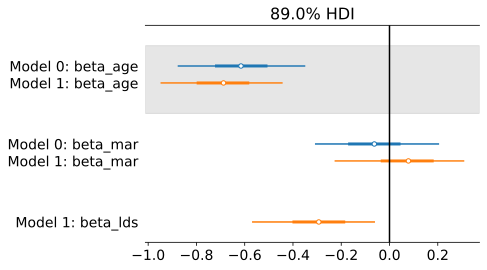

In [51]:
fig, ax = plt.subplots()

az.plot_forest([trace_1, trace_2], combined=True, hdi_prob=.89, var_names=['beta_age', 'beta_mar', 'beta_lds'], ax=ax)
ax.axvline(0, color='black')

plt.show()

### 5M5.
One way to reason through multiple causation hypotheses is to imagine detailed mechanisms
through which predictor variables may influence outcomes. For example, it is sometimes argued that
the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome
variable). However, there are at least two important mechanisms by which the price of gas could
reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to
less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals.
Can you outline one or more multiple regressions that address these two mechanisms? Assume you
can have any predictor data you need.

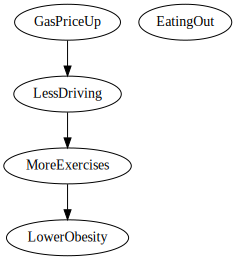

In [52]:
dag = CausalGraphicalModel(
    nodes=['GasPriceUp', 'LowerObesity', 'LessDriving', 'MoreExercises', 'EatingOut'],
    edges=[
        ('GasPriceUp', 'LessDriving'),
        ('LessDriving', 'MoreExercises'),
        ('MoreExercises', 'LowerObesity'),
    ]
)
dag.draw()

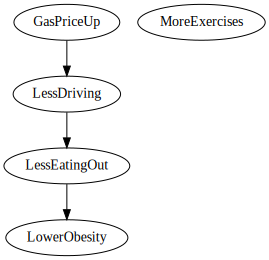

In [53]:
dag = CausalGraphicalModel(
    nodes=['GasPriceUp', 'LowerObesity', 'LessDriving', 'MoreExercises', 'LessEatingOut'],
    edges=[
        ('GasPriceUp', 'LessDriving'),
        ('LessDriving', 'LessEatingOut'),
        ('LessEatingOut', 'LowerObesity'),
    ]
)
dag.draw()

### 5H1.
In the divorce example, suppose the DAG is: $M → A → D$. What are the implied conditional independencies of the graph? Are the data consistent with it?

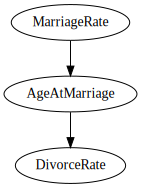

In [54]:
dag = CausalGraphicalModel(
    nodes=['MarriageRate', 'AgeAtMarriage', 'DivorceRate'],
    edges=[
        ('MarriageRate', 'AgeAtMarriage'),
        ('AgeAtMarriage', 'DivorceRate'),
    ]
)
dag.draw()

In [55]:
dag.get_all_independence_relationships()

[('DivorceRate', 'MarriageRate', {'AgeAtMarriage'})]

In [56]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', 0, .2)
    beta_mar = pm.Normal('beta_mar', 0, .5)
    
    mar = pm.Data('mar', age_std(d['Marriage']))
    
    mu = pm.Deterministic('mu', alpha + beta_mar*mar)
    sigma = pm.Exponential('sigma', 1)
    
    div = pm.Normal('div', mu, sigma, observed=div_std(d['Divorce']))
    trace_1 = pm.sample()

<ipython-input-56-b5db158c370b>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_mar, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8951280302660936, but should be close to 0.8. Try to increase the number of tuning steps.


In [57]:
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', 0, .2)
    beta_age = pm.Normal('beta_age', 0, .5)
    beta_mar = pm.Normal('beta_mar', 0, .5)
    
    age = pm.Data('age', age_std(d['MedianAgeMarriage']))
    mar = pm.Data('mar', mar_std(d['Marriage']))
    
    mu = pm.Deterministic('mu', alpha + beta_age*age + beta_mar*mar)
    sigma = pm.Exponential('sigma', 1)
    
    div = pm.Normal('div', mu, sigma, observed=div_std(d['Divorce']))
    trace_2 = pm.sample()

<ipython-input-57-8c0be2a96b95>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_2 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_mar, beta_age, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


If this DAG is true, then we expect that we will beta_mar will be useful on model 1 and useless on model 2.

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


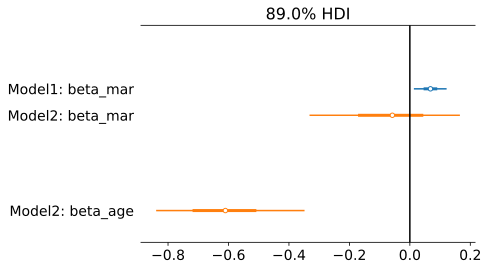

In [58]:
fig, ax = plt.subplots()

az.plot_forest([trace_1, trace_2], model_names=['Model1', 'Model2'], var_names=['beta_mar', 'beta_age'], hdi_prob=.89, combined=True, ax=ax)
ax.axvline(0, color='black')

plt.show()

That seems to be case. As soon as we add the age as a predictor marriageRate stops being a useful predictor. This concludes that in indeed the dag is compatible with the data

### 5H2.
Assuming that the DAG for the divorce example is indeed $M → A → D$, fit a new model and use it to estimate the counterfactual effect of halving a State’s marriage rate M. Use the counterfactual example from the chapter (starting on page 140) as a template.

In [59]:
with pm.Model() as model_3:
    alpha_age = pm.Normal('alpha_age', 0, .2)
    beta_mar = pm.Normal('beta_mar', 0, .5)
    mar = pm.Data('mar', mar_std(d['Marriage']))
    mu_age = pm.Deterministic('mu_age', alpha_age + beta_mar*mar)
    sigma_age = pm.Exponential('sigma_age', 1)
    age_pred = pm.Normal('age_pred', mu_age, sigma_age, observed=age_std(d['MedianAgeMarriage']))
    
    
    alpha_div = pm.Normal('alpha_div', 0, .2)
    beta_age = pm.Normal('beta_age', 0, .5)
    age = pm.Data('age', age_std(d['MedianAgeMarriage']))
    mu_div = pm.Deterministic('mu_div', alpha_div + beta_age*age)
    sigma_div = pm.Exponential('sigma_div', 1)
    div_pred = pm.Normal('div_pred', mu_div, sigma_div, observed=div_std(d['Divorce']))
    
    trace_3 = pm.sample()

<ipython-input-59-5b12ca53e790>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_3 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_div, beta_age, alpha_div, sigma_age, beta_mar, alpha_age]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [60]:
az.summary(trace_3, var_names=['~mu_age', '~mu_div'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_age,0.000,0.092,-0.151,0.196,0.002,0.002,"3,297.000","1,680.000",1.000
beta_mar,-0.692,0.098,-0.873,-0.509,0.002,0.001,"2,513.000","1,557.000",1.000
alpha_div,-0.002,0.101,-0.203,0.175,0.002,0.002,"3,125.000","1,556.000",1.000
beta_age,-0.568,0.113,-0.775,-0.355,0.002,0.002,"2,870.000","1,737.000",1.000
sigma_age,0.713,0.076,0.580,0.859,0.002,0.001,"1,875.000","1,644.000",1.000
sigma_div,0.821,0.083,0.671,0.975,0.002,0.001,"2,989.000","1,721.000",1.000


In [61]:
mar_seq = np.linspace(-3, 3, 30)

age_mu_seq = trace_3['alpha_age'] + np.outer(mar_seq, trace_3['beta_mar'])
age_sim_seq = stats.norm(age_mu_seq, trace_3['sigma_age']).rvs()

div_mu_seq = trace_3['alpha_div'] + np.multiply(age_sim_seq, trace_3['beta_age'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


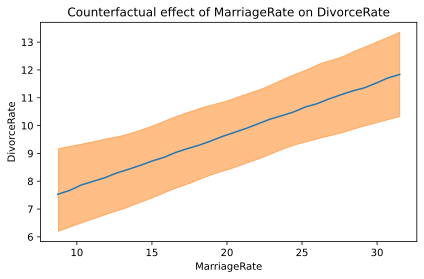

In [62]:
fig, ax = plt.subplots()


ax.set_title('Counterfactual effect of MarriageRate on DivorceRate')
ax.set_xlabel('MarriageRate')
ax.set_ylabel('DivorceRate')
ax.plot(mar_dstd(mar_seq), div_dstd(div_mu_seq.mean(axis=1)))
az.plot_hdi(mar_dstd(mar_seq), div_dstd(div_mu_seq.T), hdi_prob=.89, ax=ax)

fig.tight_layout()
plt.show()

### 5H3.
Return to the milk energy model, `m5.7`. Suppose that the true causal relationship among the
variables is:

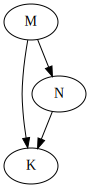

In [63]:
dag = CausalGraphicalModel(
    nodes=['M', 'N', 'K'],
    edges=[
        ('M', 'N'),
        ('M', 'K'),
        ('N', 'K')
    ]
)
dag.draw()

Now compute the counterfactual effect on $K$ of doubling $M$. You will need to account for both the
direct and indirect paths of causation. Use the counterfactual example from the chapter (starting on
page 140) as a template.

In [64]:
d = pd.read_csv('../../data/milk.csv', sep=';')

In [65]:
std_K, dstd_K = create_standardizer_destandardizer(d['kcal.per.g'])
std_N, dstd_N = create_standardizer_destandardizer(d['neocortex.perc'])
std_M, dstd_M = create_standardizer_destandardizer(np.log(d['mass']))

In [66]:
d['K'] = std_K(d['kcal.per.g'])
d['N'] = std_N(d['neocortex.perc'])
d['M'] = std_M(np.log(d['mass']))

In [67]:
d = d.dropna(subset=['K', 'N', 'M'])

In [68]:
with pm.Model() as model:
    # Model 1: M->N
    alpha_N = pm.Normal('alpha_N', 0, .2)
    beta_M_N = pm.Normal('beta_M_N', 0, .5)
    mu_N = alpha_N + beta_M_N*d['M']
    sigma_N = pm.Exponential('sigma_N', 1)
    N_pred = pm.Normal('N_pred', mu_N, sigma_N, observed=d['N'])
    
    # Model 2: M,N -> K
    alpha_K = pm.Normal('alpha_K', 0, .2)
    beta_M_K = pm.Normal('beta_M_K', 0, .5)
    beta_N_K = pm.Normal("beta_N_K", 0, .5)
    mu_K = alpha_K + beta_M_K*d['M'] + beta_N_K*d['N']
    sigma_K = pm.Exponential('sigma_K', 1)
    K_pred = pm.Normal('K_pred', mu_K, sigma_K, observed=d['K'])
    
    trace = pm.sample()

<ipython-input-68-8a1d660e5ff2>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_K, beta_N_K, beta_M_K, alpha_K, sigma_N, beta_M_N, alpha_N]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [69]:
M_seq = np.linspace(-3, 3, 50)

mu_N_seq = trace['alpha_N'] + np.outer(M_seq, trace['beta_M_N'])
sim_N_seq = stats.norm(mu_N_seq, trace['sigma_N']).rvs()

mu_K_seq = trace['alpha_K'] + np.outer(M_seq, trace['beta_M_K']) + np.multiply(sim_N_seq, trace['beta_N_K'])
sim_K_seq = stats.norm(mu_K_seq, trace['sigma_K']).rvs()

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


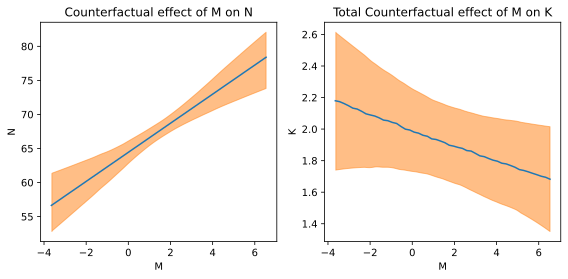

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.set_title("Counterfactual effect of M on N")
ax1.set_xlabel("M")
ax1.set_ylabel("N")
ax1.plot(dstd_M(M_seq), dstd_N(mu_N_seq.mean(axis=1)))
az.plot_hdi(dstd_M(M_seq), dstd_N(mu_N_seq.T), hdi_prob=.89, ax=ax1)


ax2.set_title("Total Counterfactual effect of M on K")
ax2.set_xlabel("M")
ax2.set_ylabel("K")
ax2.plot(dstd_M(M_seq), np.exp(dstd_K(mu_K_seq.mean(axis=1))))
az.plot_hdi(dstd_M(M_seq), np.exp(dstd_K(mu_K_seq.T)), hdi_prob=.89, ax=ax2)

fig.tight_layout()
plt.show()

### 5H4.
Here is an open practice problem to engage your imagination. In the divorce date, States in the southern United States have many of the highest divorce rates. Add the South indicator variable to the analysis. First, draw one or more DAGs that represent your ideas for how Southern American culture might influence any of the other three variables ($D$, $M$ or $A$). Then list the testable implications of your DAGs, if there are any, and fit one or more models to evaluate the implications. What do you think the influence of “Southerness” is?

In [82]:
SOUTH_STATES = [
    "Texas",
    "Florida",
    "Georgia",
    "North Carolina",
    "Virginia",
    "Tennessee",
    "Maryland",
    "South Carolina",
    "Alabama",
    "Louisiana",
    "Kentucky",
    "Oklahoma",
    "Arkansas",
    "Mississippi",
    "West Virginia",
    "Delaware",
]

d = pd.read_csv('../../data/WaffleDivorce.csv', sep=';')

age_std, age_dstd = create_standardizer_destandardizer(d['MedianAgeMarriage'])
div_std, div_dstd = create_standardizer_destandardizer(d['Divorce'])
mar_std, mar_dstd = create_standardizer_destandardizer(d['Marriage'])

d['Region'] = d['Location'].isin(SOUTH_STATES).astype(int)

#### Dag 1

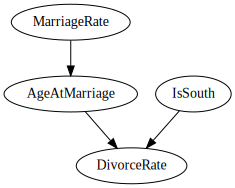

In [83]:
dag = CausalGraphicalModel(
    nodes=['MarriageRate', 'AgeAtMarriage', 'DivorceRate', 'IsSouth'],
    edges=[
        ('MarriageRate', 'AgeAtMarriage'),
        ('AgeAtMarriage', 'DivorceRate'),
        ('IsSouth', 'DivorceRate')
    ]
)
dag.draw()

In [84]:
dag.get_all_independence_relationships()

[('DivorceRate', 'MarriageRate', {'AgeAtMarriage'}),
 ('DivorceRate', 'MarriageRate', {'AgeAtMarriage', 'IsSouth'}),
 ('AgeAtMarriage', 'IsSouth', set()),
 ('AgeAtMarriage', 'IsSouth', {'MarriageRate'}),
 ('MarriageRate', 'IsSouth', set()),
 ('MarriageRate', 'IsSouth', {'AgeAtMarriage'}),
 ('MarriageRate', 'IsSouth', {'AgeAtMarriage', 'DivorceRate'})]

**Testable Implications for IsSouth**
- MarriageRate and IsSouth shouldn't have any relations
- AgeAtMarriage and IsSouth shouldn't have any relations

In [89]:
with pm.Model() as model_11:
    alpha = pm.Normal('alpha', 0, .5)
    beta_age = pm.Normal('beta_age', 0, .2)
    
    mu = alpha + beta_age*age_std(d['MedianAgeMarriage'])
    sigma = pm.Exponential('sigma', 1)
    
    div = pm.Normal('div', mu, sigma, observed=div_std(d['Divorce']))
    
    trace_11 = pm.sample()

az.summary(trace_11)

<ipython-input-89-66292f0ae46a>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_age, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.118,-0.207,0.230,0.002,0.003,"2,449.000","1,473.000",1.000
beta_age,-0.439,0.107,-0.646,-0.245,0.002,0.002,"2,118.000","1,338.000",1.000
sigma,0.836,0.089,0.682,1.007,0.002,0.001,"1,787.000","1,486.000",1.000


In [90]:
with pm.Model() as model_12:
    alpha = pm.Normal('alpha', 0, .5)
    beta_reg = pm.Normal('beta_reg', 0, .2, shape=d['Region'].nunique())
    
    mu = alpha + beta_reg[d['Region']]
    sigma = pm.Exponential('sigma', 1)
    
    div = pm.Normal('div', mu, sigma, observed=div_std(d['Divorce']))
    
    trace_12 = pm.sample()

az.summary(trace_12)

<ipython-input-90-0f108ce79585>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_12 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_reg, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.066,0.188,-0.300,0.407,0.006,0.004,"1,061.000","1,378.000",1.000
beta_reg[0],-0.191,0.174,-0.504,0.146,0.005,0.004,"1,171.000","1,391.000",1.000
beta_reg[1],0.187,0.176,-0.125,0.532,0.005,0.004,"1,293.000","1,119.000",1.000
sigma,0.969,0.102,0.774,1.147,0.003,0.002,"1,404.000","1,076.000",1.000


In [91]:
with pm.Model() as model_13:
    alpha = pm.Normal('alpha', 0, .5)
    beta_age = pm.Normal('beta_age', 0, .2)
    beta_reg = pm.Normal('beta_reg', 0, .2, shape=d['Region'].nunique())
    
    mu = alpha + beta_age*age_std(d['MedianAgeMarriage']) + beta_reg[d['Region']]
    sigma = pm.Exponential('sigma', 1)
    
    div = pm.Normal('div', mu, sigma, observed=div_std(d['Divorce']))
    
    trace_13 = pm.sample()

az.summary(trace_13)

<ipython-input-91-b8f30bb6ff0d>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_13 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_reg, beta_age, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.050,0.182,-0.283,0.385,0.005,0.004,"1,204.000","1,335.000",1.010
beta_age,-0.420,0.101,-0.610,-0.231,0.002,0.002,"1,656.000","1,508.000",1.000
beta_reg[0],-0.164,0.170,-0.476,0.156,0.005,0.003,"1,238.000","1,423.000",1.000
beta_reg[1],0.178,0.168,-0.140,0.480,0.005,0.003,"1,305.000","1,478.000",1.000
sigma,0.806,0.087,0.658,0.974,0.002,0.002,"1,391.000","1,392.000",1.000


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


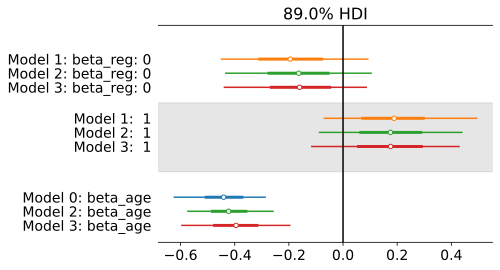

In [97]:
fig, ax = plt.subplots()

az.plot_forest([trace_11, trace_12, trace_13, trace_14], var_names=['beta_reg', 'beta_age'], combined=True, hdi_prob=.89, ax=ax)
ax.axvline(0, color='black')

plt.show()

Yeap, that seems to work